In [19]:
import time
import os

import numpy as np
import tensorflow as tf
import cv2

import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

PROJECT_DIR = os.getcwd()

BOOK_IMAGE_DIR = "bookImages"
BOOK_VIDEO_DIR = "mp4Videos"

TEST_IMAGE_DIR = "testImages"

In [2]:
def generate_book_images(book_number):
    print("current working directory:", os.getcwd())

    current_image_dir = BOOK_IMAGE_DIR + "/book" + str(book_number)
    print("current_image_dir:", current_image_dir)

    current_video_dir = BOOK_VIDEO_DIR + "/book" + str(book_number) + ".mp4"
    print("current_video_dir:", current_video_dir)

    # creates a VideoCapture object to capture the object
    capture = cv2.VideoCapture(current_video_dir)

    os.makedirs(current_image_dir, exist_ok=True)
    os.chdir(current_image_dir)
    print("current working directory:", os.getcwd())

    i = 0
    while capture.isOpened:
        # read a new frame from capture
        # ret is a boolean that stores the success of the read
        # frame is a ndarray with shape (x, y, 3) with the 3 representing RGB color values
        ret, frame = capture.read()

        if ret:
            cv2.imwrite("img" + str(i) + ".jpg", frame)
        else:
            print("ret was false. i is", str(i))
            break

        i += 1

In [40]:
def create_dataset():
    batch_size = 32
    img_height = 180
    img_width = 180

    data_dir = os.path.join(PROJECT_DIR, BOOK_IMAGE_DIR)
    print("data_dir:", data_dir)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    print(class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_ds:
        print(image_batch.shape)
        print(labels_batch.shape)
        break

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    normalization_layer = layers.Rescaling(1. / 255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    # Notice the pixel values are now in `[0,1]`.
    print(np.min(first_image), np.max(first_image))

    num_classes = len(class_names)

    model = Sequential([
        layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()

    epochs=2
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    sunflower_url = os.path.join(os.path.join(PROJECT_DIR, TEST_IMAGE_DIR), "img324.jpg")
    # sunflower_url = sunflower_url.replace("\\", "/")
    sunflower_path = tf.keras.utils.get_file(sunflower_url, origin=sunflower_url)

    img = tf.keras.utils.load_img(
        sunflower_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

data_dir: C:\dev\juniper\tensorflow0\bookImages
Found 1008 files belonging to 3 classes.
Using 807 files for training.
Found 1008 files belonging to 3 classes.
Using 201 files for validation.
['book1', 'book2', 'book3']
(32, 180, 180, 3)
(32,)
0.0 0.9918291
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                           

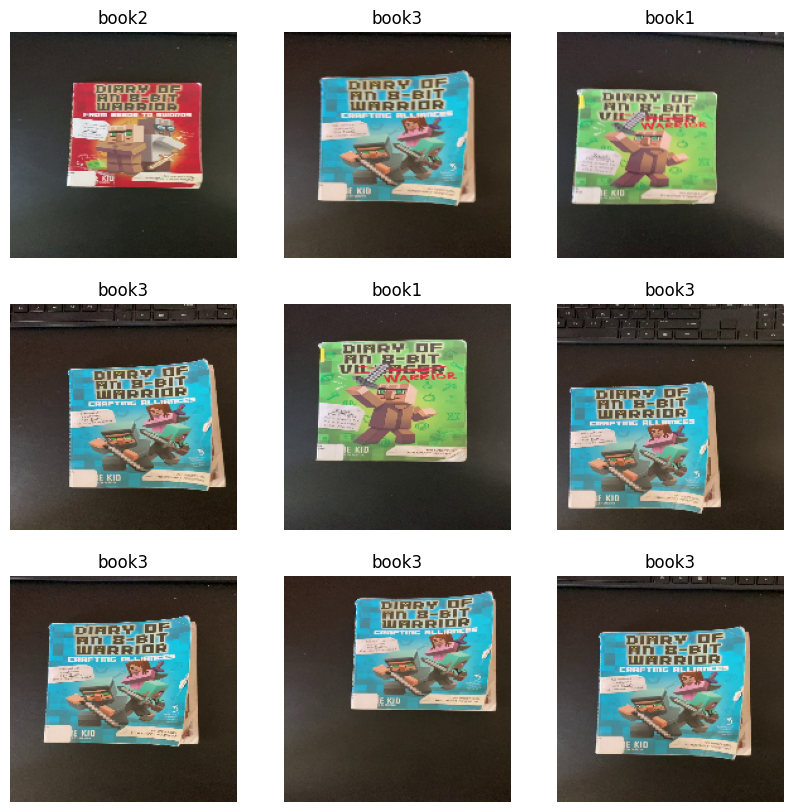

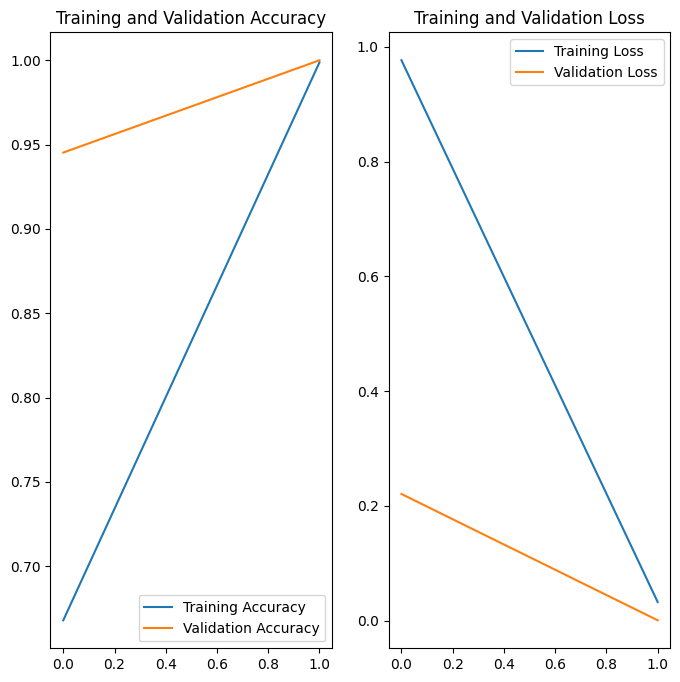

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to book1 with a 99.91 percent confidence.


In [41]:
if __name__ == "__main__":
    create_dataset()